# Credit Scoring
Ashwani Nitharwal


## Survival Analysis
Importing Libraries, packages and dataset

In [20]:
#importing packages
import lifelines # pip install lifelines
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
#importing dataset
mortgage = pd.read_csv('Data/mortgage.csv')
mortgage = mortgage.dropna()

## Data Preprocessing and exploration
Data was not having any string values and it was all in numbers for categorical as well as binary variables. 

For data exploration, below are the plots.

In [4]:
#exploring dataset
mortgage.shape

(622219, 23)

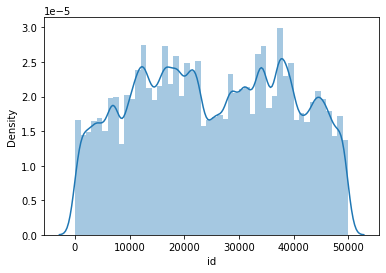

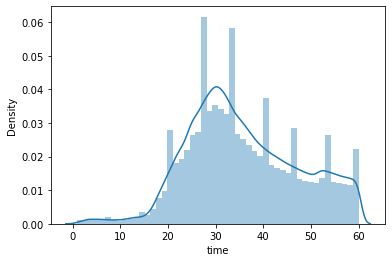

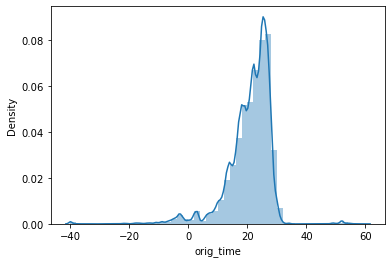

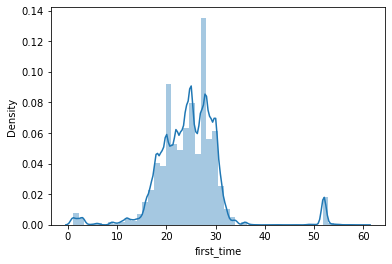

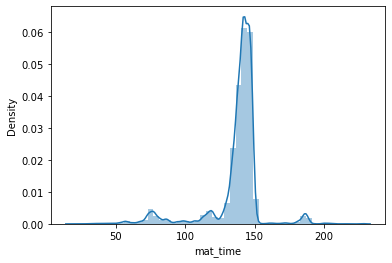

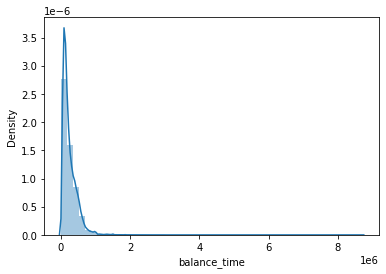

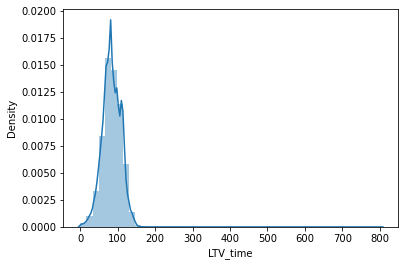

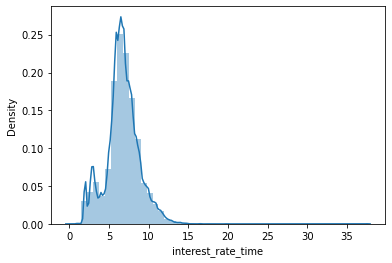

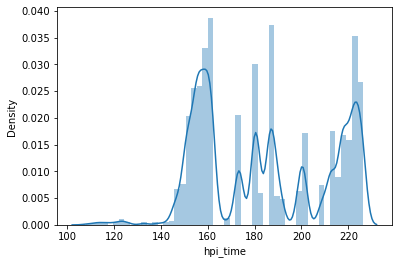

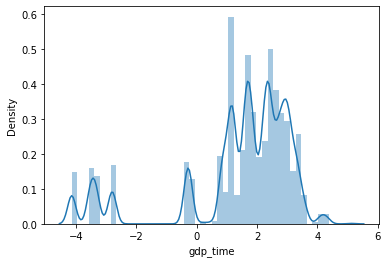

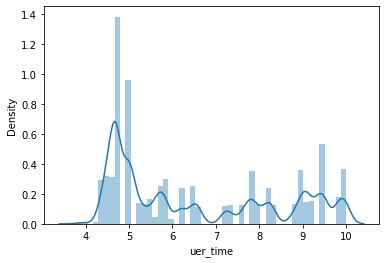

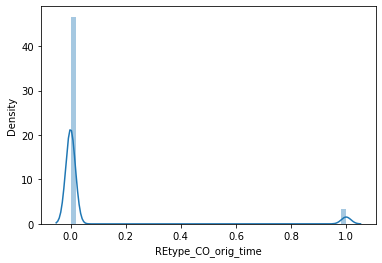

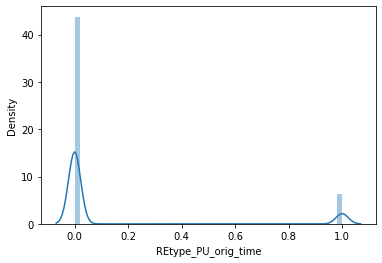

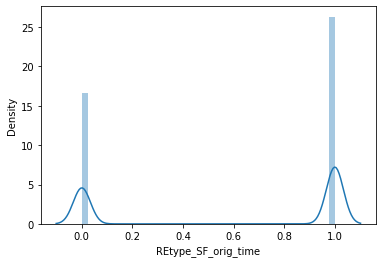

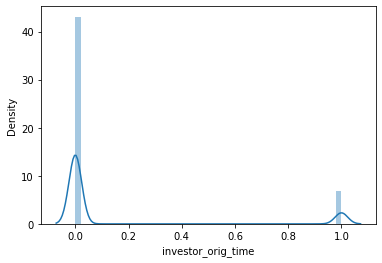

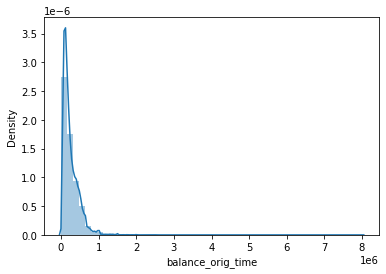

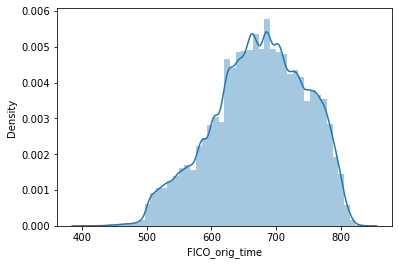

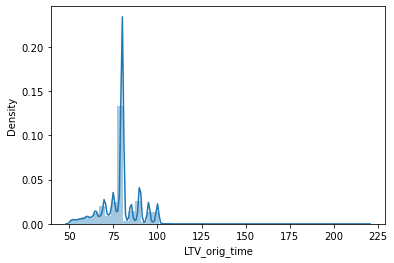

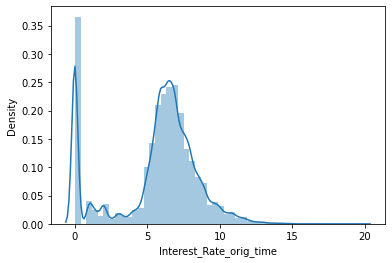

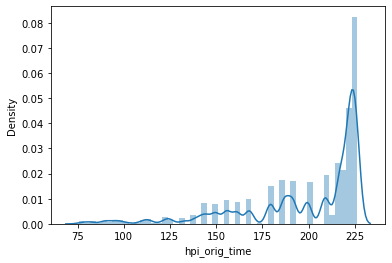

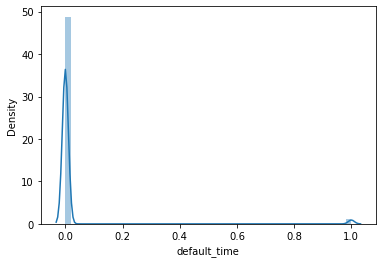

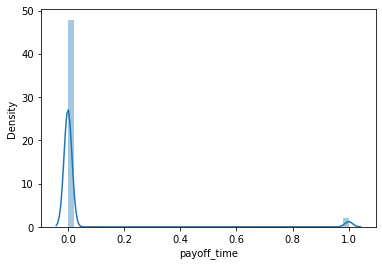

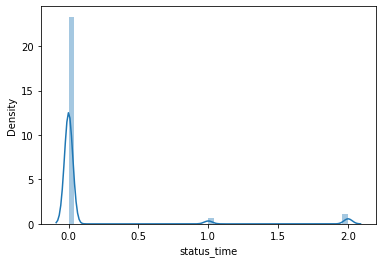

In [21]:
for i, col in enumerate(mortgage.columns):
    plt.figure(i)
    sns.distplot(mortgage[col])

We can see the above plots which give us idea about the distribution of the data. We can see that there are categorical variables, binary variables and continuous variables too. 

- I split the data between the low balance at origin time and high balance at origin time by the 30% quantile and created 2 groups for the comparison of their default time.

The balance at which the groups are splitted is: balance_orig_time = 121900

In [42]:
# 30% quantile is set to distinguish group for analysis
limit = mortgage.balance_orig_time.quantile(0.3)
limit

121900.0

In [43]:
# creating variable as per quantile criteria on balance_orig_time
mortgage['limit'] = mortgage['balance_orig_time'].apply(lambda x: 1 if x>limit else 0)

In [44]:
# convert episodic data to static
mortgage_static = mortgage.groupby("id").agg(np.max).reset_index()

In [45]:
mortgage_static.head(5)

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time,limit
0,1,48,-7,25,113,41303.42,28.963629,9.200,226.29,3.029499,...,0,45000.0,715,69.4,9.200,87.03,1,0,1,0
1,2,26,18,25,138,105826.38,65.469851,7.680,226.29,2.899137,...,0,107200.0,558,80.0,7.680,186.91,0,1,2,0
2,3,29,-6,25,114,44866.18,31.459735,11.375,226.29,2.899137,...,0,48600.0,680,83.6,8.750,89.58,0,1,2,0
3,4,60,-2,25,119,61031.10,49.156858,11.000,226.29,3.029499,...,0,63750.0,587,81.8,10.500,97.99,0,0,0,0
4,5,27,18,25,138,52295.07,66.346343,9.155,226.29,2.899137,...,0,52800.0,527,80.0,9.155,186.91,0,1,2,0


Sample Analysis to compare the default time

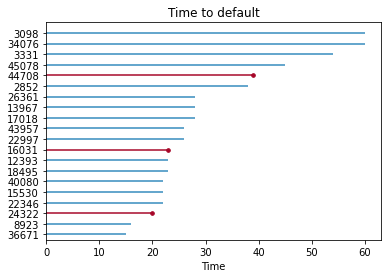

In [46]:
# sample to analyze the default people
from lifelines.plotting import plot_lifetimes

df_samp = mortgage_static.sample(20)
ax = plot_lifetimes(df_samp["time"], event_observed=df_samp["default_time"])
ax.set_xlabel("Time")
ax.set_title("Time to default")
plt.show()

KaplanMeierFitter model is used below to analyze the whole population and their default time.
The below plot shows the probability of non-default people

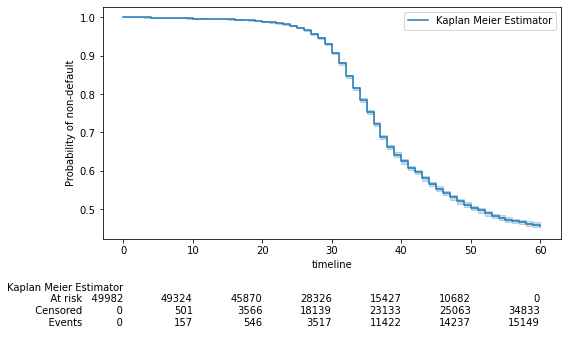

In [47]:
# analysis on default of all data
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
# fit on static data: time indicates the last observed timestep, default_time indicates whether the customer defaulted
kmf.fit(mortgage_static['time'], mortgage_static['default_time'], label='Kaplan Meier Estimator')

# plot survival function
ax = kmf.plot_survival_function(at_risk_counts=True,figsize=(8,5))
ax.set_ylabel('Probability of non-default')
plt.show()

Below Vertical line shows the median of the distribution of the default time of all the population

35.0


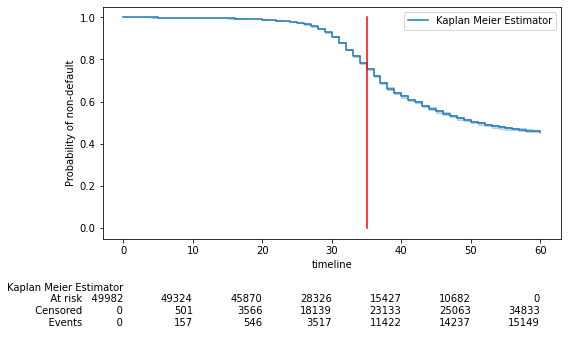

In [48]:
# Median default_time analysis comparison
median_default = mortgage_static.query("default_time==1")["time"].median()
print(median_default)

# add to plot
ax = kmf.plot_survival_function(at_risk_counts=True,figsize=(8,5))
ax.set_ylabel('Probability of non-default')
plt.plot([median_default, median_default], [0,1], 'k-', c="red")
plt.show()

## Comparison of the group divided based on balance_orig_time
Two groups are aplitted on the basis of the 30% quantile and then they are analyzed 

Below model and plot brings out the comparison of the two groups

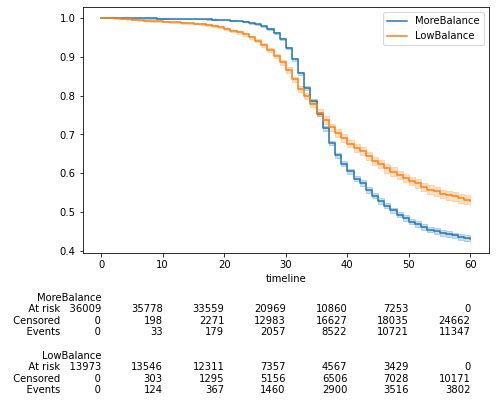

In [49]:
# Compare two groups based on the limit set for 30% quantile

kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

fig, ax = plt.subplots(1,1 , figsize=(7,6))

# subset data
df1 = mortgage_static.loc[mortgage_static["limit"] == 1,:]
df2 = mortgage_static.loc[mortgage_static["limit"] == 0,:]

# fit subset gender = male
ax = kmf1.fit(df1['time'], df1['default_time'], label='MoreBalance').plot_survival_function(ax=ax)

# fit subset gender = female
ax = kmf2.fit(df2['time'], df2['default_time'], label='LowBalance').plot_survival_function(ax=ax)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf1, kmf2, ax=ax)
plt.tight_layout()

In [50]:
# Perform logrank test to assess whether there is a difference between low and high balance in time to default

pd.options.display.float_format = '{:.18f}'.format
from lifelines.statistics import logrank_test

# Null-Hypothesis: No difference between the two groups
res = logrank_test(df1['time'], df2['time'], event_observed_A=df1['default_time'],event_observed_B=df2['default_time'])

# We can reject the Null-Hypothesis (p < 0.05)
print(res.summary)
pd.reset_option('^display.', silent=True)

         test_statistic                    p              -log2(p)
0 59.951170700994275364 0.000000000000009724 46.547369412408265532


In [57]:
# "predict" probability to default at time

print("Low Balance - after 25 months:",1 - kmf1.predict(25))
print("High Balance - after 25 months:",1 - kmf2.predict(25))
print("")
print("Low Balance - after 50 months:",1 - kmf1.predict(50))
print("High Balance - after 50 months:",1 - kmf2.predict(50))

Low Balance - after 25 months: 0.015968894025092384
High Balance - after 25 months: 0.05822314611770307

Low Balance - after 50 months: 0.5252472374758186
High Balance - after 50 months: 0.4197415899398509


## Time-Varying COX-Proportional Hazard Model

In [52]:
# select variables used in previous model + time varying variables
mort = pd.merge(mortgage[["id","first_time","default_time", "hpi_time", "gdp_time", "uer_time", "balance_time"\
                          ,"interest_rate_time", "FICO_orig_time", "LTV_time"]], mortgage_static[["id", "time"]]\
                .rename(columns={"time":"time_end"}), on="id", how="inner") 
mort["first_time"] = 0

In [53]:
from lifelines import CoxTimeVaryingFitter
pd.options.display.float_format = '{:.5f}'.format
# Note: credit_tv contains both time varying and static variables 
ctv = CoxTimeVaryingFitter()
ctv.fit(mort, id_col="id", event_col="default_time", start_col="first_time", stop_col="time_end", show_progress=True)
ctv.summary

Iteration 9: norm_delta = 0.00000, step_size = 1.00000, ll = -193453.17044, newton_decrement = 0.00000, seconds_since_start = 118.3Convergence completed after 9 iterations.


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
hpi_time,-0.00774,0.99229,0.00069,-0.00909,-0.00639,0.99095,0.99363,0.00000,-11.25036,0.00000,95.13015
gdp_time,-0.07845,0.92455,0.00422,-0.08672,-0.07018,0.91693,0.93223,0.00000,-18.58513,0.00000,253.70437
uer_time,-0.16202,0.85042,0.00807,-0.17785,-0.14620,0.83707,0.86398,0.00000,-20.07052,0.00000,295.23374
balance_time,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,27.22828,0.00000,539.88674
interest_rate_time,0.17180,1.18744,0.00344,0.16505,0.17855,1.17945,1.19548,0.00000,49.87995,0.00000,inf
FICO_orig_time,-0.00447,0.99554,0.00012,-0.00471,-0.00424,0.99530,0.99577,0.00000,-36.92599,0.00000,989.11145
LTV_time,0.00825,1.00828,0.00014,0.00799,0.00852,1.00802,1.00855,0.00000,61.06526,0.00000,inf


In [54]:
# inspect p-values
round(ctv.summary['p'], 4)

covariate
hpi_time             0.00000
gdp_time             0.00000
uer_time             0.00000
balance_time         0.00000
interest_rate_time   0.00000
FICO_orig_time       0.00000
LTV_time             0.00000
Name: p, dtype: float64

<AxesSubplot:xlabel='log(HR) (95% CI)'>

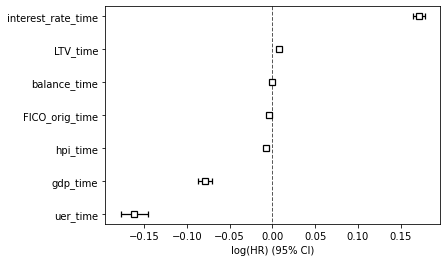

In [55]:
ctv.plot()

In [59]:
# print parameter values
print(round(ctv.params_, 6))

covariate
hpi_time             -0.00774
gdp_time             -0.07845
uer_time             -0.16202
balance_time          0.00000
interest_rate_time    0.17180
FICO_orig_time       -0.00447
LTV_time              0.00825
dtype: float64


In [64]:
# Results interpretation: 

print('\n An additional increase in balance could have increased the probability of Low balance by 0%')

print('\n An additional increase in Interest Rate could have increased the probability of Low balance by {:.3f}%'.format((np.exp(0.17180) - 1)*100))

print('\n An additional increase in Unemployment Rate (due in the future) increases the probability of Low balance by {:.3f}%'.format((np.exp(-0.16202) - 1)*100))

print('\n An additional increase in GDP (due in the future) increases the probability of Low balance by {:.3f}%'.format((np.exp(-0.07845) - 1)*100))


 An additional increase in balance could have increased the probability of Low balance by 0%

 An additional increase in Interest Rate could have increased the probability of Low balance by 18.744%

 An additional increase in Unemployment Rate (due in the future) increases the probability of Low balance by -14.958%

 An additional increase in GDP (due in the future) increases the probability of Low balance by -7.545%
